# RF & XGBoost Modelling

In [97]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [133]:
train_data = Path("__file__").parent / "data" /"train_full.csv"
test_data = Path("__file__").parent / "data" /"test_full.csv"
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)

original_df = pd.concat([train_df, test_df], axis=0)
df = original_df.copy()

In [134]:
df.head()

,year_month,year,month,precipitation_mean,precipitation_sum,max_temp_mean,max_temp_max,min_temp_mean,min_temp_min,avg_temp_mean,avg_temp_std,precipitation_count,price_usd_per_tonne_mean,price_usd_per_tonne_std,Mid Rate_mean,Mid Rate_std
0,1996-01-01,1996,1,-0.861464,-1.011531,0.462460,-0.238712,0.947776,1.934933,0.438983,0.376641,0,1349.541364,10.184784,1469.078409,14.536908
1,1996-02-01,1996,2,-0.861464,-1.011531,0.462460,-0.238712,0.838467,1.934933,1.344259,-0.256773,0,1369.839524,17.896659,1518.639000,13.286225
2,1996-03-01,1996,3,-0.861464,-1.011531,0.462460,-0.238712,0.729157,1.934933,1.222199,0.619708,0,1338.600952,26.267301,1561.531500,11.793660
3,1996-04-01,1996,4,-0.861464,-1.011531,0.016635,-0.155776,0.619848,1.934933,1.079796,3.327665,0,1456.279524,31.037661,1595.029250,8.399923
4,1996-05-01,1996,5,0.786976,0.665290,-0.429190,-0.072839,0.491019,0.027792,-0.191387,1.888106,14,1524.020455,17.324733,1618.618636,7.556588


## Process Data

In [135]:
df.drop(columns=["year_month"], inplace=True)

### Lags

In [136]:
num_lags = 3

features_to_lag = list(df.columns)
features_to_lag.remove("year")
features_to_lag.remove("month")

for lag in range(1, num_lags + 1):
    for feature in features_to_lag:
        df[f"expected_{feature}_lag_{lag}"] = df[feature].shift(lag)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [137]:
df.head()

,year,month,precipitation_mean,precipitation_sum,max_temp_mean,max_temp_max,min_temp_mean,min_temp_min,avg_temp_mean,avg_temp_std,...,expected_max_temp_max_lag_3,expected_min_temp_mean_lag_3,expected_min_temp_min_lag_3,expected_avg_temp_mean_lag_3,expected_avg_temp_std_lag_3,expected_precipitation_count_lag_3,expected_price_usd_per_tonne_mean_lag_3,expected_price_usd_per_tonne_std_lag_3,expected_Mid Rate_mean_lag_3,expected_Mid Rate_std_lag_3
0,1996,4,-0.861464,-1.011531,0.016635,-0.155776,0.619848,1.934933,1.079796,3.327665,...,-0.238712,0.947776,1.934933,0.438983,0.376641,0.0,1349.541364,10.184784,1469.078409,14.536908
1,1996,5,0.786976,0.665290,-0.429190,-0.072839,0.491019,0.027792,-0.191387,1.888106,...,-0.238712,0.838467,1.934933,1.344259,-0.256773,0.0,1369.839524,17.896659,1518.639000,13.286225
2,1996,6,-0.319452,-0.657095,-0.694143,-1.137191,-0.760184,-0.265617,-0.875702,0.064939,...,-0.238712,0.729157,1.934933,1.222199,0.619708,0.0,1338.600952,26.267301,1561.531500,11.793660
3,1996,7,-0.032956,0.553617,-1.520652,-1.068077,-1.056734,-0.705726,-1.763279,-1.134600,...,-0.155776,0.619848,1.934933,1.079796,3.327665,0.0,1456.279524,31.037661,1595.029250,8.399923
4,1996,8,-0.340090,-0.064477,-1.699671,2.525838,-1.079308,0.086471,-1.960771,-1.146772,...,-0.072839,0.491019,0.027792,-0.191387,1.888106,14.0,1524.020455,17.324733,1618.618636,7.556588


# Model Training & Prediction

In [103]:
metrics = {}

In [104]:
X = df.drop(columns=features_to_lag)
y = df[features_to_lag]

In [105]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=100,
    n_jobs=-1,
)
rf_model = MultiOutputRegressor(rf_model)

In [106]:
# use walk forward validation
train_window_size = 24
test_window_size = 3

label_index = y.columns.get_loc("price_usd_per_tonne_mean")

rmse = []
mae = []
mse = []
rf_predictions = []
ground_truth = []

for i in tqdm(range(0, (len(X) - train_window_size) // test_window_size)):
    start_train = i * test_window_size
    end_train = start_train + train_window_size
    start_test = end_train
    end_test = start_test + test_window_size
    X_train = X.iloc[start_train:end_train]
    y_train = y.iloc[start_train:end_train]
    X_test = X.iloc[start_test:end_test]
    y_test = y.iloc[start_test:end_test]

    rf_model.fit(X_train, y_train)

    for test_month in range(test_window_size):
        X_test_month = X_test.iloc[test_month].copy()
        expected_values = rf_model.predict(X_test_month.to_frame().T)[0]

        for lag in range(num_lags, 1, -1):
            for feature in features_to_lag:
                X_test_month.loc["expected_" + feature + "_lag_" + str(lag)] = X_test_month.loc[
                    "expected_" + feature + "_lag_" + str(lag - 1)
                ]

        for feature, expected_value in zip(features_to_lag, expected_values):
            X_test_month.loc["expected_" + feature + "_lag_1"] = expected_value

        rf_predictions.append(expected_values[label_index])
        ground_truth.append(y_test.iloc[test_month, label_index])

100%|██████████| 106/106 [06:56<00:00,  3.93s/it]


In [108]:
metrics["Random Forest"] = {
    "MAE": mean_absolute_error(rf_predictions, ground_truth),
    "MSE": mean_squared_error(rf_predictions, ground_truth),
    "RMSE": root_mean_squared_error(rf_predictions, ground_truth),
}

# Plot

In [181]:
date_spacing = 15
dates = original_df.loc[:, "year_month"][3:]
dates = [dates.split("-")[0] + "-" + dates.split("-")[1] for dates in dates]

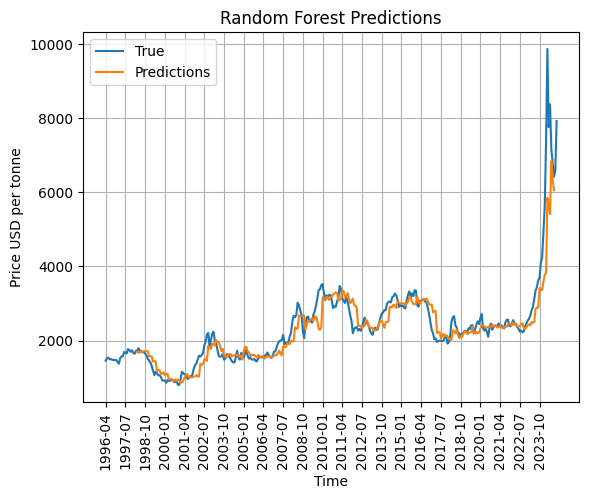

In [184]:
# overlay predictions
plt.plot(y.iloc[:, label_index], label="True")
plt.plot(
    range(train_window_size, train_window_size + len(rf_predictions)),
    rf_predictions,
    label="Predictions",
)
plt.xticks(ticks = range(0, len(dates), date_spacing), labels = dates[::date_spacing], rotation=90)
plt.grid()

plt.title("Random Forest Predictions")
plt.xlabel("Time")
plt.ylabel("Price USD per tonne")
plt.legend()

In [111]:
xg_model = GradientBoostingRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=100,
)
xg_model = MultiOutputRegressor(xg_model)

In [112]:
train_window_size = 24
test_window_size = 3

label_index = y.columns.get_loc("price_usd_per_tonne_mean")

rmse = []
mae = []
mse = []
xgboost_predictions = []
ground_truth = []

for i in tqdm(range(0, (len(X) - train_window_size) // test_window_size)):
    start_train = i * test_window_size
    end_train = start_train + train_window_size
    start_test = end_train
    end_test = start_test + test_window_size
    X_train = X.iloc[start_train:end_train]
    y_train = y.iloc[start_train:end_train]
    X_test = X.iloc[start_test:end_test]
    y_test = y.iloc[start_test:end_test]

    xg_model.fit(X_train, y_train)

    for test_month in range(test_window_size):
        X_test_month = X_test.iloc[test_month].copy()
        expected_values = xg_model.predict(X_test_month.to_frame().T)[0]

        for lag in range(num_lags, 1, -1):
            for feature in features_to_lag:
                X_test_month.loc["expected_" + feature + "_lag_" + str(lag)] = X_test_month.loc[
                    "expected_" + feature + "_lag_" + str(lag - 1)
                ]

        for feature, expected_value in zip(features_to_lag, expected_values):
            X_test_month.loc["expected_" + feature + "_lag_1"] = expected_value

        xgboost_predictions.append(expected_values[label_index])
        ground_truth.append(y_test.iloc[test_month, label_index])

100%|██████████| 106/106 [03:49<00:00,  2.16s/it]


In [113]:
metrics["XGBoost"] = {
    "MAE": mean_absolute_error(xgboost_predictions, ground_truth),
    "MSE": mean_squared_error(xgboost_predictions, ground_truth),
    "RMSE": root_mean_squared_error(xgboost_predictions, ground_truth),
}

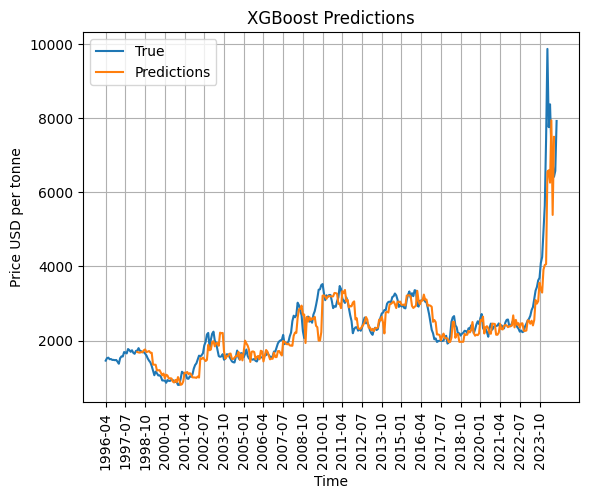

In [186]:
plt.plot(y.iloc[:, label_index], label="True")
plt.plot(range(train_window_size, train_window_size + len(xgboost_predictions)), xgboost_predictions, label="Predictions")
plt.xticks(ticks = range(0, len(dates), date_spacing), labels = dates[::date_spacing], rotation=90)
plt.grid()

plt.title("XGBoost Predictions")
plt.xlabel("Time")
plt.ylabel("Price USD per tonne")
plt.legend()

## Analysis

In [116]:
print(pd.DataFrame(metrics).T)

                      MAE            MSE        RMSE
Random Forest  243.129506  226340.866101  475.752946
XGBoost        242.994210  191137.311606  437.192534


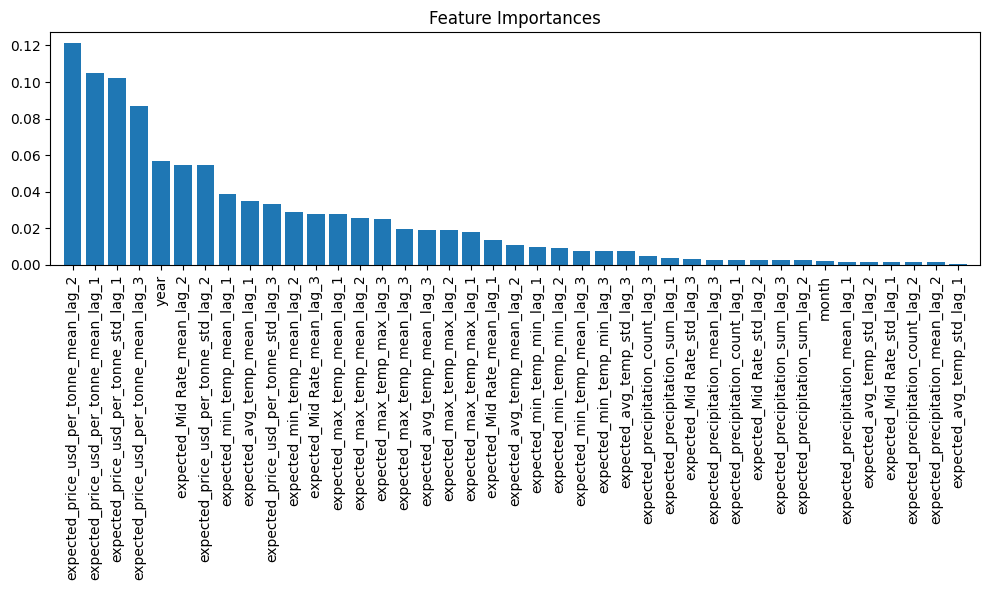

In [125]:
importances = rf_model.estimators_[label_index].feature_importances_.reshape(1, -1)
importances = np.mean(importances, axis=0)
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()